# 🤖 Modelagem Preditiva: Atrasos de Voos (Fase 3)

**Objetivo:** Treinar e avaliar modelos de Machine Learning para prever se um voo atrasará 5 minutos ou mais (`IS_DELAYED_5MIN`), com uma antecedência de 30 minutos da chegada prevista.

**Observação sobre os Dados:**
O dataset carregado (`df_final`) já foi pré-processado para conter apenas voos **já decolados** no momento da previsão (T-30 min). Casos determinísticos (onde o voo nem havia decolado) já foram removidos.

**Modelos Selecionados:**
1.  **LightGBM:** Foco em velocidade e eficiência.
2.  **CatBoost:** Foco em precisão com variáveis categóricas (`AIRPORT`, `AIRLINE`).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Bibliotecas de Boosting
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# Configurações
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

## 1. Carregamento de Dados

In [7]:
%%time
df_model = pd.read_parquet('../data/df_final.parquet')

if 'df_model' in locals():
    print(f"Dataset Carregado: {df_model.shape}")
    print(f"Pronto para modelagem. Linhas: {df_model.shape[0]}")
else:
    print("Dataframe não carregado.")

Dataset Carregado: (5476235, 18)
Pronto para modelagem. Linhas: 5476235
CPU times: user 2.1 s, sys: 2.7 s, total: 4.79 s
Wall time: 2.09 s


## 2. Preparação de Variáveis (Encoding Nativo)

Para LightGBM e CatBoost, não faremos One-Hot Encoding. Vamos converter as colunas de texto (`object`) para o tipo `category`. Os modelos lidarão com isso internamente.

In [8]:
# Lista de colunas categóricas
cat_cols = ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE']

print("Convertendo colunas para 'category'...")
for col in cat_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype('category')
    
# Verificação dos tipos
print(df_model[cat_cols].dtypes)

# Definição de X e y
X = df_model.drop(columns=['IS_DELAYED_5MIN'])
y = df_model['IS_DELAYED_5MIN']

# Split Treino/Teste (70/30)
# Usamos stratify=y para manter a mesma proporção de atrasos nos dois sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Convertendo colunas para 'category'...
ORIGIN_AIRPORT         category
DESTINATION_AIRPORT    category
AIRLINE                category
dtype: object
Treino: (3833364, 17), Teste: (1642871, 17)


## 3. Modelo 1: LightGBM

O LightGBM é extremamente rápido e lida bem com grandes volumes de dados.

In [9]:
%%time
print("--- Treinando LightGBM ---")

# Configuração do Dataset do LightGBM (otimizado)
# Indicamos explicitamente quais são as colunas categóricas
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
d_test = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols, reference=d_train)

# Parâmetros (Baseline robusto)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,       # Controla complexidade
    'learning_rate': 0.05,  # Taxa de aprendizado
    'feature_fraction': 0.9,# Amostragem de colunas
    'is_unbalance': True,   # Lida com o desbalanceamento de classes automaticamente
    'n_jobs': -1,           # Usa todos os cores da CPU
    'verbose': -1
}

# Treinamento com Early Stopping
model_lgb = lgb.train(
    params,
    d_train,
    num_boost_round=1000,
    valid_sets=[d_train, d_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

print("Treinamento LightGBM concluído.")

--- Treinando LightGBM ---
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.932952	valid_1's auc: 0.932786
[200]	training's auc: 0.938131	valid_1's auc: 0.937464
[300]	training's auc: 0.940929	valid_1's auc: 0.939745
[400]	training's auc: 0.942825	valid_1's auc: 0.941145
[500]	training's auc: 0.944361	valid_1's auc: 0.942208
[600]	training's auc: 0.945447	valid_1's auc: 0.942845
[700]	training's auc: 0.946419	valid_1's auc: 0.943431
[800]	training's auc: 0.947258	valid_1's auc: 0.943895
[900]	training's auc: 0.948081	valid_1's auc: 0.944355
[1000]	training's auc: 0.948731	valid_1's auc: 0.944693
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.948731	valid_1's auc: 0.944693
Treinamento LightGBM concluído.
CPU times: user 1h 39min, sys: 2min 37s, total: 1h 41min 37s
Wall time: 30min 9s


### 3.1 Avaliação do LightGBM

--- Relatório LightGBM ---
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92   1210741
         1.0       0.75      0.84      0.79    432130

    accuracy                           0.89   1642871
   macro avg       0.85      0.87      0.86   1642871
weighted avg       0.89      0.89      0.89   1642871

AUC-ROC: 0.9447


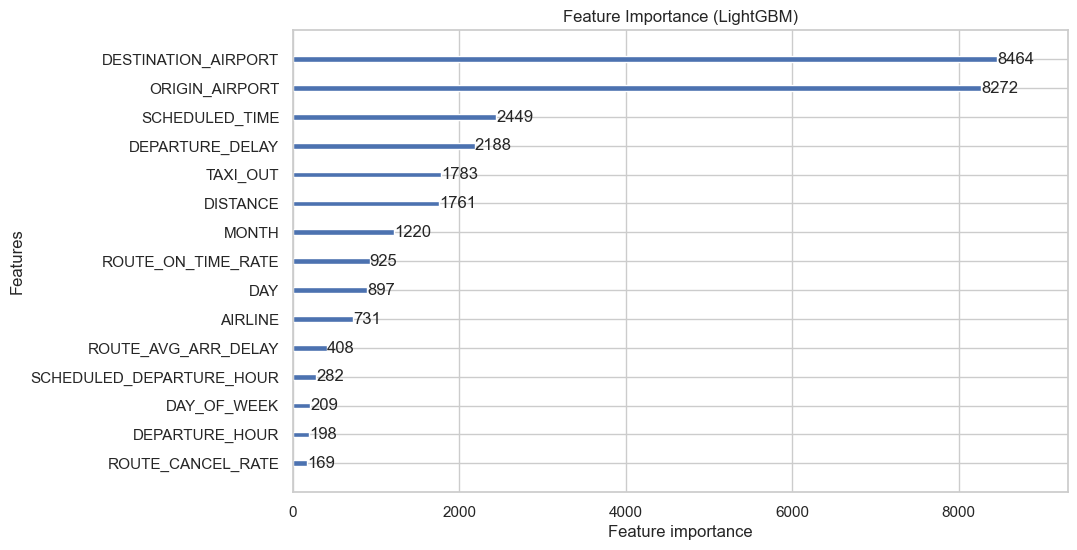

Feature Importance Ordenado pelo método 'Split'
                     feature  importance_split
4        DESTINATION_AIRPORT              8464
3             ORIGIN_AIRPORT              8272
7             SCHEDULED_TIME              2449
5            DEPARTURE_DELAY              2188
6                   TAXI_OUT              1783
8                   DISTANCE              1761
0                      MONTH              1220
15        ROUTE_ON_TIME_RATE               925
1                        DAY               897
9                    AIRLINE               731
12       ROUTE_AVG_ARR_DELAY               408
10  SCHEDULED_DEPARTURE_HOUR               282
2                DAY_OF_WEEK               209
11            DEPARTURE_HOUR               198
13         ROUTE_CANCEL_RATE               169
14         ROUTE_DIVERT_RATE                43
16       IS_REGIONAL_AIRPORT                 1

Feature Importance Ordenado pelo método 'Split'
                     feature  importance_gain
5          

In [15]:
# Previsão (retorna probabilidades)
y_pred_prob_lgb = model_lgb.predict(X_test)

# Converter para binário (threshold default 0.5)
y_pred_lgb = (y_pred_prob_lgb >= 0.5).astype(int)

print("--- Relatório LightGBM ---")
print(classification_report(y_test, y_pred_lgb))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob_lgb):.4f}")

# Feature Importance Plot
lgb.plot_importance(model_lgb, max_num_features=15, title='Feature Importance (LightGBM)', figsize=(10, 6), importance_type='split')
plt.show()

# Tabela  de Feature importance
feature_names = model_lgb.feature_name()

# importance_type='split' é o padrão do gráfico (quantas vezes a feature foi usada)
# importance_type='gain' é muitas vezes mais preciso (o quanto a feature reduziu o erro)
importance_values_split = model_lgb.feature_importance(importance_type='split')
importance_values_gain = model_lgb.feature_importance(importance_type='gain')

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance_split': importance_values_split,
    'importance_gain': importance_values_gain
})
df_importance = df_importance.sort_values(by='importance_split', ascending=False)
print("Feature Importance Ordenado pelo método 'Split'")
print(df_importance[['feature','importance_split']].head(20))

print("\nFeature Importance Ordenado pelo método 'Split'")
print(df_importance[['feature','importance_gain']].sort_values(by='importance_gain', ascending=False).head(20))

## 4. Modelo 2: CatBoost

O CatBoost geralmente lida melhor com categóricas sem precisar de muito ajuste.

In [17]:
%%time
print("--- Treinando CatBoost ---")

# CatBoost lida com NaNs e Categóricas nativamente
model_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    cat_features=cat_cols,
    auto_class_weights='Balanced', # Importante para o desbalanceamento
    verbose=100,
    task_type="CPU" # Mude para GPU se tiver disponível
)

model_cb.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

print("Treinamento CatBoost concluído.")

--- Treinando CatBoost ---
0:	test: 0.8940665	best: 0.8940665 (0)	total: 10.2s	remaining: 1h 25m 2s
100:	test: 0.9315221	best: 0.9315221 (100)	total: 8m 48s	remaining: 34m 46s
200:	test: 0.9354675	best: 0.9354675 (200)	total: 13m 58s	remaining: 20m 46s
300:	test: 0.9374376	best: 0.9374376 (300)	total: 17m 45s	remaining: 11m 44s
400:	test: 0.9387915	best: 0.9387915 (400)	total: 21m 49s	remaining: 5m 23s
499:	test: 0.9398067	best: 0.9398067 (499)	total: 25m 40s	remaining: 0us

bestTest = 0.9398066807
bestIteration = 499

Treinamento CatBoost concluído.
CPU times: user 1h 8min 1s, sys: 28min 18s, total: 1h 36min 19s
Wall time: 26min 2s


### 4.1 Avaliação do CatBoost

--- Relatório CatBoost ---
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92   1210741
         1.0       0.75      0.83      0.79    432130

    accuracy                           0.88   1642871
   macro avg       0.84      0.87      0.85   1642871
weighted avg       0.89      0.88      0.88   1642871

AUC-ROC: 0.9398


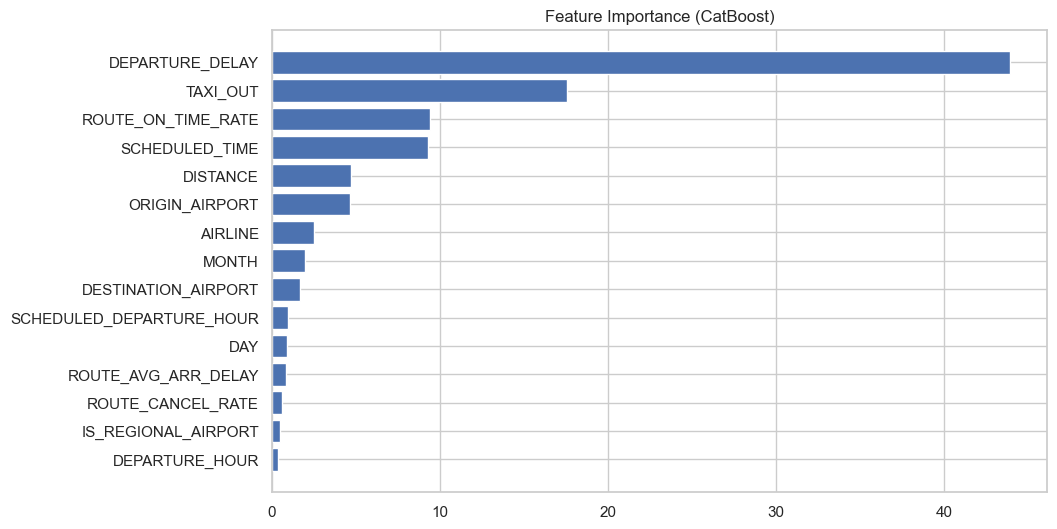

In [18]:
y_pred_prob_cb = model_cb.predict_proba(X_test)[:, 1]
y_pred_cb = model_cb.predict(X_test)

print("--- Relatório CatBoost ---")
print(classification_report(y_test, y_pred_cb))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob_cb):.4f}")

# Feature Importance
feature_importance = model_cb.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance (CatBoost)')
plt.show()

## 5. Comparativo Final (Curva ROC)

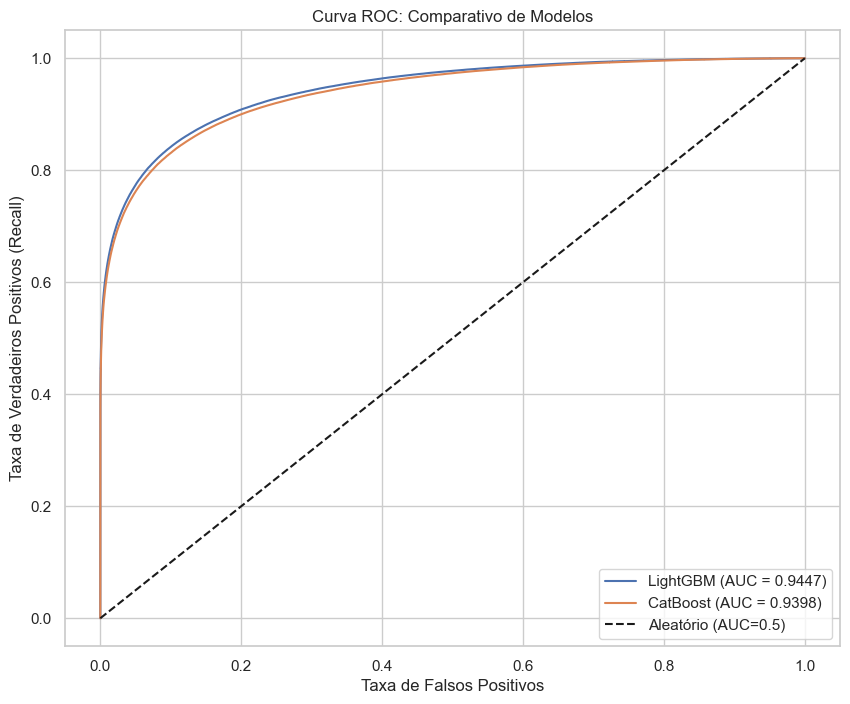

In [19]:
plt.figure(figsize=(10, 8))

# LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_prob_lgb)
auc_lgb = roc_auc_score(y_test, y_pred_prob_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.4f})')

# CatBoost
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_pred_prob_cb)
auc_cb = roc_auc_score(y_test, y_pred_prob_cb)
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC=0.5)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC: Comparativo de Modelos')
plt.legend()
plt.show()